In [95]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [97]:
df  = pd.read_csv("creditcard.csv")[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [98]:
X = df.drop(columns=["Time", "Amount", "Class"]).values
y = df["Class"].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [99]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0:1, 1:2},max_iter=1000)
mod.fit(X,y).predict(X).sum()

171

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer
# I NEED `make_scorer` FOR THIS
# def min_precision_recall(y_true, y_pred):
#     precision = precision_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     return min(precision, recall)

# NO LONGER NEED 'make_scorer
def min_precision_recall(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return min(precision, recall)



grid = GridSearchCV (
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight':[{0:1, 1:v} for v in np.linspace(1,20,30)]},
    scoring= {'precision':make_scorer(precision_score, greater_is_better=True), 
              'recall':make_scorer(recall_score, greater_is_better=True),
              'min_both':min_precision_recall},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X,y)

KeyboardInterrupt: 

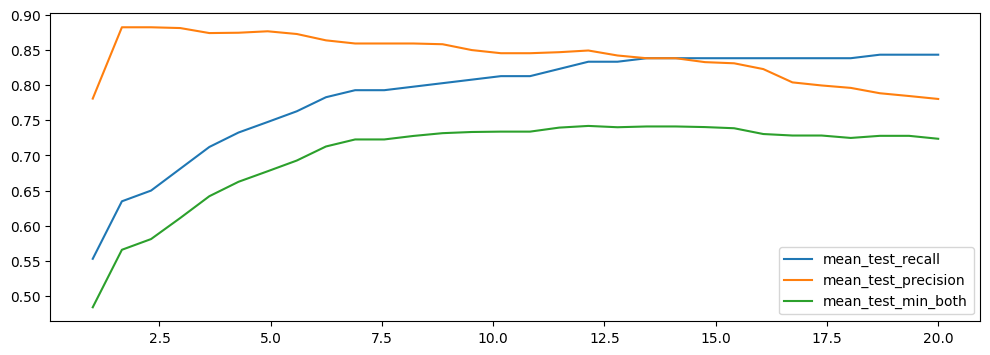

In [57]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
             df[score],
             label=score)

plt.legend()    

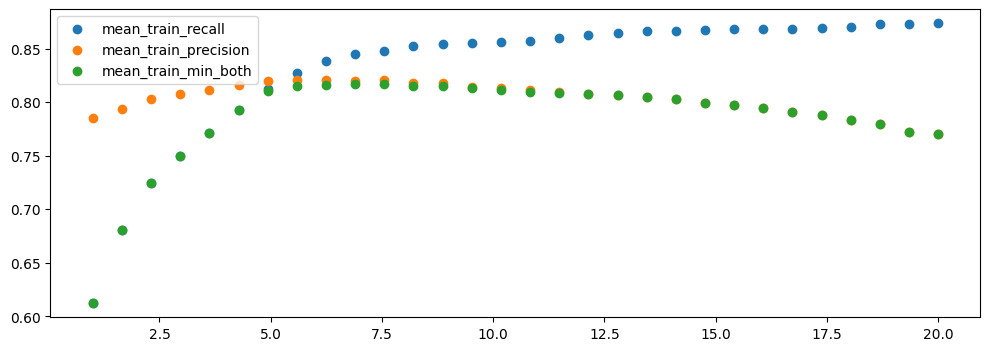

In [58]:
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall', 'mean_train_precision', 'mean_train_min_both']:
    plt.scatter(x=[_[1] for _ in df['param_class_weight']], 
                y=df[score.replace('test', 'train')], 
                label=score)
plt.legend();

# Using Outlier Detection Models

In [59]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
# Beacuse initialy sklearn assumes -1 is outlier. We translate it to fraud my replacing -1 with 1.
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)

grid.fit(X,y)

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function outlier_precision at 0x0000027651E5CE50>,
                      'recall': <function outlier_recall at 0x000002763503A670>})

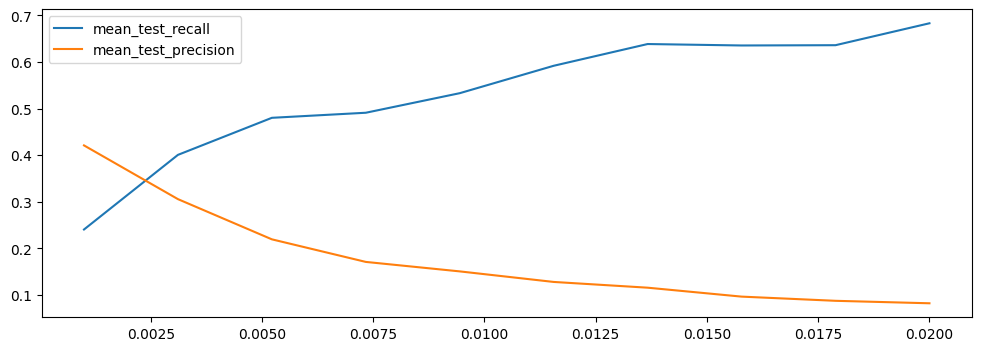

In [61]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df['param_contamination'],
                df[score],
                label=score)
plt.legend()